In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

Load the Dataset

In [3]:
df = pd.read_csv("/content/Bengaluru_House_Data1.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.shape


(13320, 9)

In [5]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df.isnull().sum()


,0
area_type,0
availability,0
location,1
size,16
society,5502
total_sqft,0
bath,73
balcony,609
price,0


In [7]:
df1=df.drop(["availability", "society"],axis="columns")
df1.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


Data Preprocessing

In [8]:
df1.isnull().sum()


,0
area_type,0
location,1
size,16
total_sqft,0
bath,73
balcony,609
price,0


In [9]:
df1['balcony'] = df1['balcony'].fillna(0)  # Fill NaNs with 0
df1['bath'] = df1['bath'].fillna(df1['bath'].median())  # Fill NaNs with medianith median
df1 = df1.dropna(subset=['size'])
df1 = df1.dropna(subset=['location'])
df1.isnull().sum()



,0
area_type,0
location,0
size,0
total_sqft,0
bath,0
balcony,0
price,0


In [10]:
df1['bhk'] = df1['size'].apply(lambda x: int(x.split(' ')[0]))

df1.bhk.unique()



array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [11]:

df1['total_sqft'].unique()[:10]

# Convert to numeric (handle ranges like "1200-1500" by taking the average)
def convert_sqft(x):
    try:
        if '-' in str(x):
            vals = x.split('-')
            return (float(vals[0]) + float(vals[1])) / 2
        else:
            return float(x)
    except:
        return None

df1['total_sqft'] = df1['total_sqft'].apply(convert_sqft)

# Drop rows with invalid `total_sqft`
df1 = df1.dropna(subset=['total_sqft'])


In [12]:
df1.shape

(13257, 8)

In [13]:
df1.area_type.unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [14]:
df1 = pd.get_dummies(df1, columns=['area_type'], drop_first=True)

Adding a feature

In [15]:
df1['price_per_sqft'] = df1['price'] * 100000 / df1['total_sqft']


In [16]:
df1.head()

,location,size,total_sqft,bath,balcony,price,bhk,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,False,False,True,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,False,True,False,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,False,False,False,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,False,False,True,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,False,False,True,4250.000000


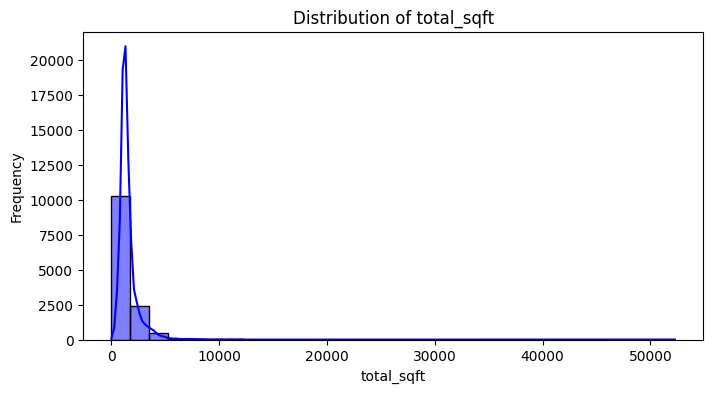

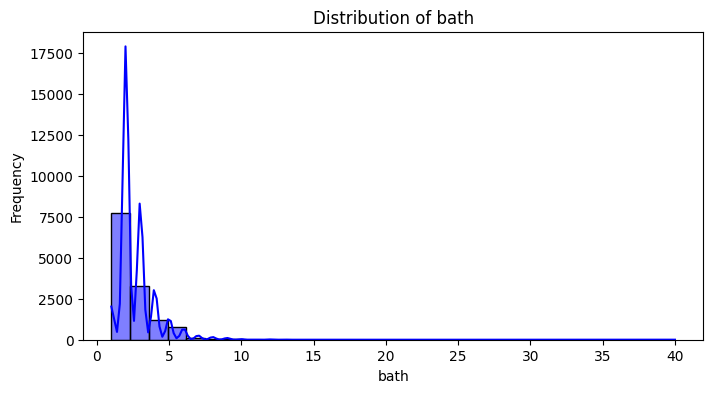

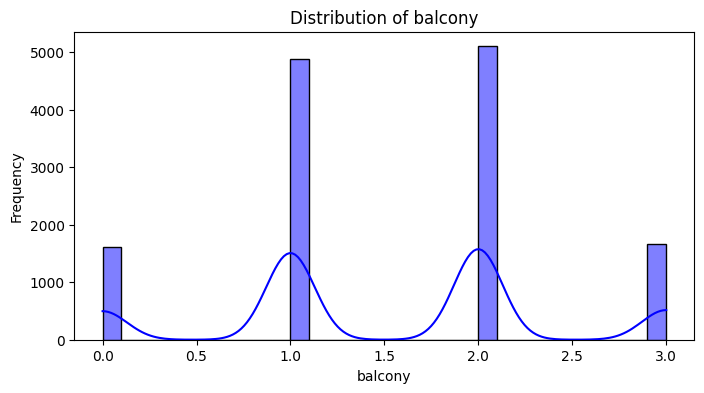

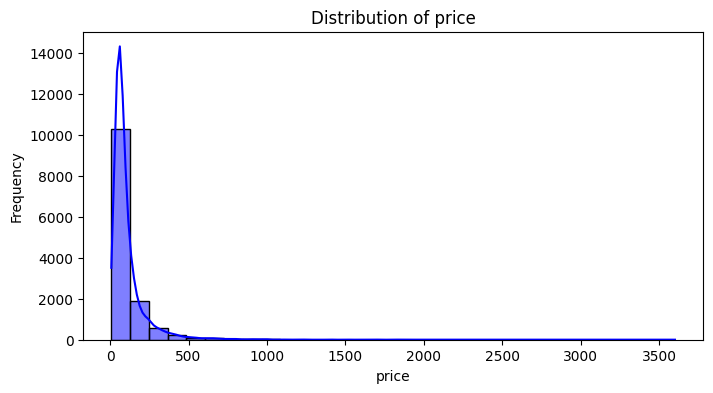

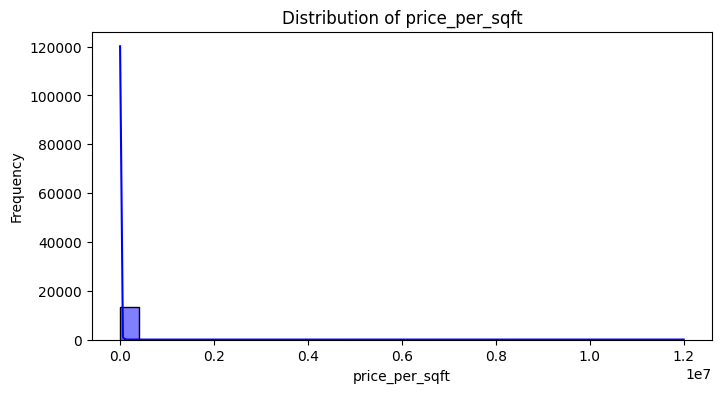

In [17]:
numerical_columns = ['total_sqft', 'bath', 'balcony', 'price', 'price_per_sqft']

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df1[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Handling Outliers

In [18]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25%)
    Q3 = data[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

price_outliers = detect_outliers_iqr(df1, 'price')
print(f"Number of outliers in price: {len(price_outliers)}")


Number of outliers in price: 1265


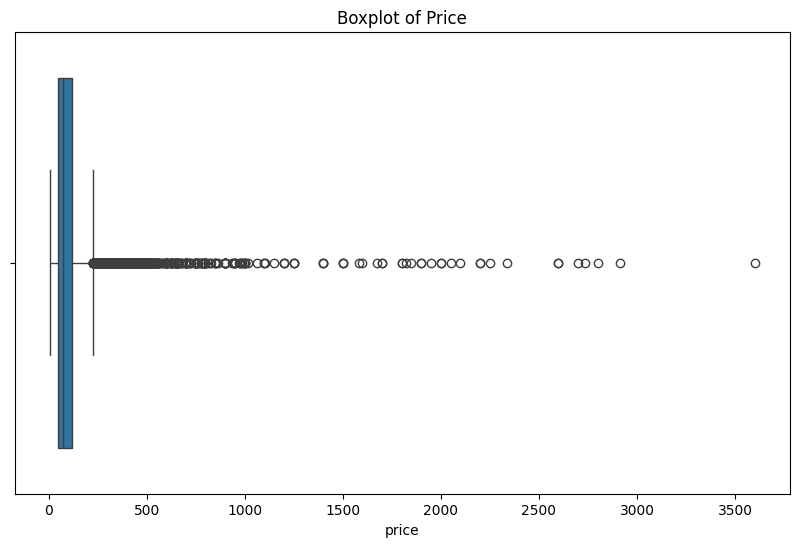

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df1['price'])
plt.title('Boxplot of Price')
plt.show()

In [20]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers from 'price'
df1 = remove_outliers_iqr(df1, 'price')


In [21]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

numerical_columns = ['total_sqft', 'bath', 'price']

# Loop through each column and remove outliers
for col in numerical_columns:
    df1 = remove_outliers_iqr(df1, col)

df1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10498 entries, 0 to 13319
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   location                        10498 non-null  object 
 1   size                            10498 non-null  object 
 2   total_sqft                      10498 non-null  float64
 3   bath                            10498 non-null  float64
 4   balcony                         10498 non-null  float64
 5   price                           10498 non-null  float64
 6   bhk                             10498 non-null  int64  
 7   area_type_Carpet  Area          10498 non-null  bool   
 8   area_type_Plot  Area            10498 non-null  bool   
 9   area_type_Super built-up  Area  10498 non-null  bool   
 10  price_per_sqft                  10498 non-null  float64
dtypes: bool(3), float64(5), int64(1), object(2)
memory usage: 768.9+ KB


In [22]:
df1.head()

,location,size,total_sqft,bath,balcony,price,bhk,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,False,False,True,3699.810606
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,False,False,False,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,False,False,True,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,False,False,True,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2,False,False,True,3247.863248


Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [23]:
df1.location = df1.location.apply(lambda x: x.strip())
location_stats = df1['location'].value_counts(ascending=False)
location_stats

,count
location,
Whitefield,414
Sarjapur Road,312
Electronic City,296
Kanakpura Road,260
Thanisandra,221
...,...
2nd Block Jayanagar,1
Ganesha Block,1
Rukmaiah Layout,1


In [24]:
location_stats.values.sum()


10498

In [25]:
len(location_stats[location_stats>10])


195

In [27]:
len(location_stats[location_stats<=10])


858

**Dimensionality Reduction**
Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [29]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

,count
location,
NRI Layout,10
Ganga Nagar,10
Banashankari Stage II,10
Basapura,10
Tindlu,10
...,...
2nd Block Jayanagar,1
Ganesha Block,1
Rukmaiah Layout,1


In [31]:
df1.location = df1.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df1.location.unique())

196

In [ ]:
df1.head()

,location,size,total_sqft,bath,balcony,price,bhk,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,price_per_sqft,location_freq
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,False,False,True,3699.810606,128
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,False,False,False,4305.555556,176
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,False,False,True,6245.890861,22
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,False,False,True,4250.000000,56
5,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2,False,False,True,3247.863248,414


In [32]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Transform 'location' column
df1['location_encoded'] = label_encoder.fit_transform(df1['location'])

# Display first few rows
print(df1[['location', 'location_encoded']].head())

                   location  location_encoded
0  Electronic City Phase II                62
2               Uttarahalli               182
3        Lingadheeranahalli               130
4                  Kothanur               124
5                Whitefield               189


In [33]:
df1 = df1.drop(['location','size'],axis='columns')
df1

,total_sqft,bath,balcony,price,bhk,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,price_per_sqft,location_encoded
0,1056.0,2.0,1.0,39.07,2,False,False,True,3699.810606,62
2,1440.0,2.0,3.0,62.00,3,False,False,False,4305.555556,182
3,1521.0,3.0,1.0,95.00,3,False,False,True,6245.890861,130
4,1200.0,2.0,1.0,51.00,2,False,False,True,4250.000000,124
5,1170.0,2.0,1.0,38.00,2,False,False,True,3247.863248,189
...,...,...,...,...,...,...,...,...,...,...
13312,1262.0,2.0,2.0,47.00,2,False,False,True,3724.247227,35
13313,1345.0,2.0,1.0,57.00,3,False,False,True,4237.918216,182
13314,1715.0,3.0,3.0,112.00,3,False,False,True,6530.612245,69
13317,1141.0,2.0,1.0,60.00,2,False,False,False,5258.545136,157


 Model

In [34]:
X = df1.drop(['price'],axis='columns')

In [35]:
y = df1.price
y

,price
0,39.07
2,62.00
3,95.00
4,51.00
5,38.00
...,...
13312,47.00
13313,57.00
13314,112.00
13317,60.00


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)


In [37]:
dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

# Evaluate the model
print("\nDecision Tree:")
print("R^2 Score:", r2_score(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))



Decision Tree:
R^2 Score: 0.9981043383816899
RMSE: 1.3054896727719778


In [38]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# Evaluate the model
print("Linear Regression:")
print("R^2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression:
R^2 Score: 0.9403595850939204
RMSE: 7.322567103219954


In [39]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("\nRandom Forest:")
print("R^2 Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))



Random Forest:
R^2 Score: 0.9994001685650675
RMSE: 0.7343576832292678


Evaluation results of models suggest that the Random Forest Regressor is performing the best among the three models tested

R² Score: 0.9994 (Extremely high; indicates an almost perfect fit to the data)
RMSE: 0.732 (Lowest error among the three models)

Cross-Validation

In [40]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(random_state=42, n_estimators=100)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive RMSE scores
rmse_scores = np.sqrt(-cv_scores)

# Print the results
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())


Cross-Validation RMSE Scores: [1.17219631 0.78379433 1.15657776 0.75303826 0.95162135]
Mean RMSE: 0.9634456028002726
Standard Deviation of RMSE: 0.17751762214410213


The Random Forest Regressor shows low error (mean RMSE) and consistency (low standard deviation).
These results confirm that the model is not overfitting and generalizes well on unseen data.

In [ ]:
import pickle

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)
